Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.fft import fft, ifft
import pickle

In [2]:
# numerical solver for the Kardar-Parisi-Zhang equation
def kpz(h, t, c, dx, v, lamb, y=1, n=0):
    Gamma = np.empty_like(h)
    # second-order central
    Gamma[1:-1] = h[2:] + h[:-2] - 2*h[1:-1]
    # second order forward
    Gamma[0] = h[2] + h[0] - 2*h[1]
    # second order backward
    Gamma[-1] = h[-1] + h[-3] - 2*h[-2]
    
    # nonlinear term
    Psi = np.empty_like(h)
    # inside terms
    Psi[1:-1] = 1/(2*y+1)*(
    (h[2:]-h[1:-1])**2 + \
    2*y*(h[2:]-h[1:-1])*(h[1:-1]-h[:-2]) + \
    (h[1:-1]-h[:-2])**2
    )
    # solution for boundary terms not explained in paper, check other papers ref [24-30]
    Psi[0] = Psi[1]
    Psi[-1] = Psi[-2]
    
    if n:
        # gaussian noise
        noise = np.random.normal(0, n, h.shape)
    else:
        noise = np.zeros_like(h)
        
    retval = c + 1/(dx**2) * (v*Gamma + Psi*lamb*0.5) + noise
    return retval

In [3]:
def eq11(a, H, n, x, t):
    # eq 11 in Campos 2013
    # Gamma is del2 h
    # Psi is (del h)^2
    c, v, lamb = a
    lamb /= 2
    _, d2h, dh2 = H
    # truncate the fourier components??

In [4]:
def err(a, x, t, h, ha):
    # eq 13 in Campos 2013
    h_a = ha(a, x, t, h[0])
    return np.average((h - h_a)**2)

Toy problem

In [5]:
# define constants
c = 0.02
v = 0.1
lamb = 0.3
D = 4.5e-6

In [6]:
# define init conds
timestamps = np.linspace(0, 10)
x = np.linspace(0, 1)
# y0 = -(np.linspace(-1, 1)**2) + 1 # creates inverted parabola
# y0 = np.sin(2*np.pi*x) # creates sine wave
y0 = np.sin(2*np.pi*x) + x # creates sine wave with linear slope

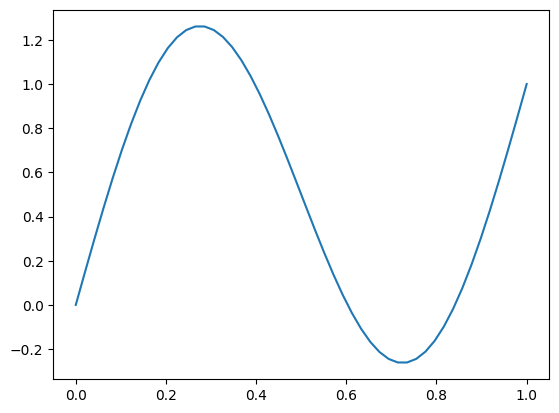

In [7]:
plt.plot(x, y0)

In [8]:
plt.clf()

<Figure size 640x480 with 0 Axes>

In [9]:
# function callable by scipy
def f(t, y):
    return kpz(y, t, c, 1, v, lamb, n=0)

In [10]:
# solve over time
h_result = solve_ivp(f, [0, 1], y0, vectorized=True)

In [11]:
front1 = h_result.y[:, 0]
front2 = h_result.y[:, -1]

In [12]:
# init all the things
a = np.array([1, 1, 1])
x = np.linspace(0, 1)
t = np.array([h_result.t[0], h_result.t[-1]])
h = np.array([front1, front2])

In [13]:
# minimize the error
def ha(a, x, t, h0):
    def func(t, y):
        return kpz(y, t, a[0], 1, a[1], a[2])
    h_a = solve_ivp(func, t, h0, vectorized=True)
    return np.array([h_a.y[:, 0], h_a.y[:, -1]])


In [14]:
ha_result = minimize(err, a, args=(x, t, h, ha))
ha_result

      fun: 3.8211263367586767e-10
 hess_inv: array([[ 2.27372856e+00,  3.48078135e+00, -2.16656104e+02],
       [ 3.48078135e+00,  7.47394345e+03, -3.03459199e+02],
       [-2.16656104e+02, -3.03459199e+02,  3.60723836e+04]])
      jac: array([-2.62425585e-06, -2.15790895e-08, -1.43519759e-07])
  message: 'Optimization terminated successfully.'
     nfev: 148
      nit: 34
     njev: 37
   status: 0
  success: True
        x: array([0.02003204, 0.09983856, 0.29411186])

In [15]:
# reconstructed kpz eqn
a_opt = ha_result.x
final = solve_ivp(lambda t, y: kpz(y, t, a_opt[0], 1, a_opt[1], a_opt[2]), [0, 1], y0, vectorized=True)

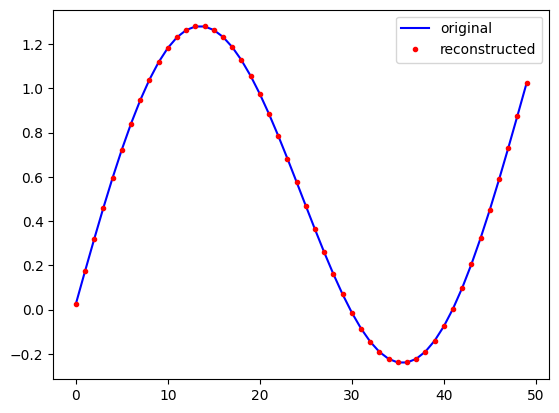

In [16]:
# compare original and reconstructed
plt.plot(front2, 'b-', label='original')
plt.plot(final.y[:, -1], 'r.', label='reconstructed')
plt.legend()

Real data

In [17]:
# load real data
filename = 'spread.pickle'
with open(filename, 'rb') as f:
    spread = pickle.load(f)

Cartesian form

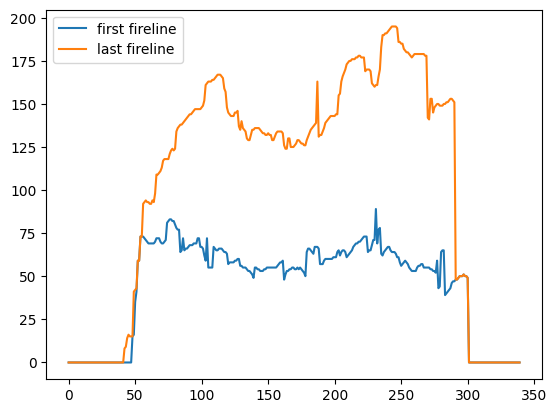

In [18]:
t = np.array([10, 30])
firstFireline = spread[t[0]]
firstx = firstFireline[0]
firsth = firstFireline[1]
# sortIdx = np.argsort(firstx)
# firstx = firstx[sortIdx]
# firsth = firsth[sortIdx]
plt.plot(firstx, firsth, label='first fireline')

lastFireline = spread[t[1]]
lastx = lastFireline[0]
lasth = lastFireline[1]
# sortIdx = np.argsort(lastx)
# lastx = lastx[sortIdx]
# lasth = lasth[sortIdx]
plt.plot(lastx, lasth, label='last fireline')
plt.legend()

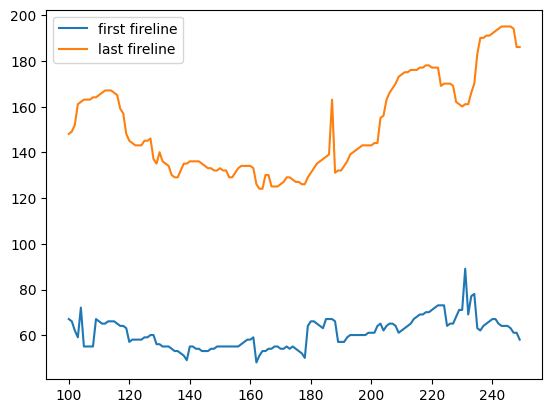

In [19]:
# specify bounds of fireline
x0 = 100
xn = 250
plt.plot(firstx[x0:xn], firsth[x0:xn], label='first fireline')
plt.plot(lastx[x0:xn], lasth[x0:xn], label='last fireline')
plt.legend()
# truncate firelines
firstx = firstx[x0:xn]
firsth = firsth[x0:xn]
lastx = lastx[x0:xn]
lasth = lasth[x0:xn]

In [20]:
# smooth the data by course graining the fourier components as in Campos 2013
n = 100
first_fft = fft(firsth)
last_fft = fft(lasth)
first_fft[n:] = 0
last_fft[n:] = 0
firsth_smooth = np.real(ifft(first_fft))
lasth_smooth = np.real(ifft(last_fft))
firstErr = np.average((firsth - firsth_smooth)**2)
lastErr = np.average((lasth - lasth_smooth)**2)
firstErr, lastErr

(10.140819775732165, 109.16659629257622)

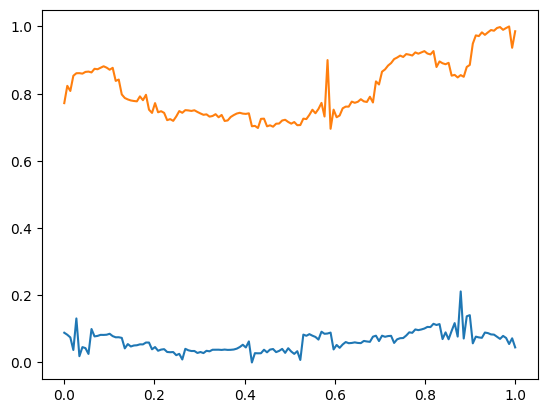

In [21]:
a = np.array([1, 1, 1]) # c v lamb
h = np.array([firsth_smooth, lasth_smooth])
# normalize the data
x = np.linspace(0, 1, len(firsth_smooth))
y_bounds = np.array([h.min(), h.max()])
h -= y_bounds[0]
h /= y_bounds[1] - y_bounds[0]
# t = np.array([0, 1], float)
plt.clf()
plt.plot(x, h[0], label='first fireline')
plt.plot(x, h[1], label='last fireline')

In [22]:
ha_result = minimize(err, a, args=(x, t, h, ha))
ha_result

      fun: 0.0028262357491392353
 hess_inv: array([[ 1.81472079e-03,  1.68923432e+00, -7.43044647e-02],
       [ 1.68923432e+00,  4.03182384e+03, -1.77387624e+02],
       [-7.43044647e-02, -1.77387624e+02,  8.80643524e+00]])
      jac: array([-2.03487819e-01,  7.52915483e-04, -1.82293588e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 55
      nit: 4
     njev: 13
   status: 2
  success: False
        x: array([0.03705583, 0.15205401, 1.03747846])

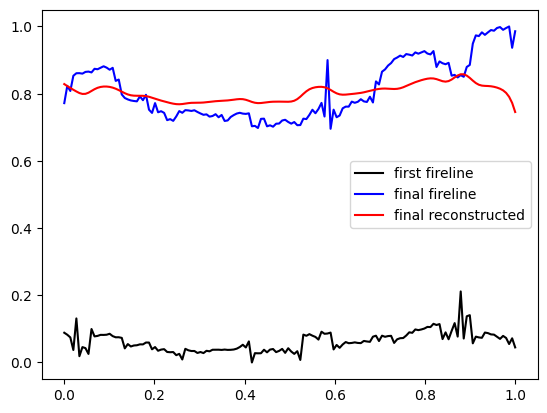

In [23]:
a_opt = ha_result.x
final = solve_ivp(lambda t, y: kpz(y, t, a_opt[0], 1, a_opt[1], a_opt[2]), t, h[0], vectorized=True)
plt.clf()
plt.plot(x, h[0], 'k-', label='first fireline')
plt.plot(x, h[1], 'b-', label='final fireline')
plt.plot(x, final.y[:, -1], 'r-', label='final reconstructed')
plt.legend()

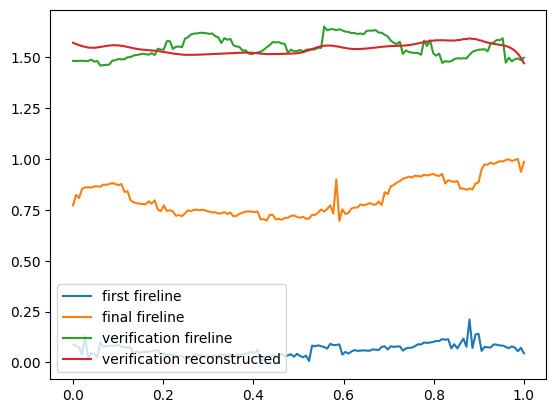

In [24]:
# verify the prediction by predicting another fireline
t[1] = 50
verifyFireline = spread[t[1]]
verifyh = verifyFireline[1]
verifyh = verifyh[x0:xn]
verifyh_smooth = fft(verifyh)
verifyh_smooth[n:] = 0
verifyh_smooth = np.real(ifft(verifyh_smooth))
verifyh_smooth -= y_bounds[0]
verifyh_smooth /= y_bounds[1] - y_bounds[0]
verify = solve_ivp(lambda t, y: kpz(y, t, a_opt[0], 1, a_opt[1], a_opt[2]), t, h[0], vectorized=True)
plt.clf()
plt.plot(x, h[0], label='first fireline')
plt.plot(x, h[1], label='final fireline')
plt.plot(x, verifyh_smooth, label='verification fireline')
plt.plot(x, verify.y[:, -1], label='verification reconstructed')
plt.legend()